In [65]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Import Generator definition and normalization from your train script
from train_cycleGAN import Generator, normalize_tensor

# --- User: Set these paths ---
data_dir = './data'  # Path to data folder containing trainA and trainB
model_path = '../../../../Downloads/G_rgb_epoch5.pth'  # Path to trained generator weights
output_dir = './generated_samples/inference/'
os.makedirs(output_dir, exist_ok=True)

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sar_channels = 2
eo_channels = 3  # For RGB
G = Generator(sar_channels, eo_channels).to(device)
G.load_state_dict(torch.load(model_path, map_location=device))
G.eval()

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(2, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Con

In [67]:
import random

sar_dir = os.path.join(data_dir, 'trainA')
eo_dir = os.path.join(data_dir, 'trainB')

# List all image files
sar_files_all = [f for f in os.listdir(sar_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
eo_files_all = [f for f in os.listdir(eo_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select 5 unique indices (ensure you don't go out of bounds)
num_samples = 5
max_samples = min(len(sar_files_all), len(eo_files_all), num_samples)
random_indices = random.sample(range(max_samples), max_samples)

sar_files = [sar_files_all[i] for i in random_indices]
eo_files = [eo_files_all[i] for i in random_indices]

sar_imgs = []
eo_imgs = []
for f in sar_files:
    img = np.array(Image.open(os.path.join(sar_dir, f)))
    if img.ndim == 3:
        img = img[..., :2]
    elif img.ndim == 2:
        img = np.stack([img, img], axis=-1)
    sar_imgs.append(img)
for f in eo_files:
    img = np.array(Image.open(os.path.join(eo_dir, f)).convert('RGB'))
    eo_imgs.append(img)

In [68]:
gen_eo_imgs = []
for i, sar in enumerate(sar_imgs):
    sar_tensor = torch.from_numpy(sar).permute(2,0,1).float()
    sar_tensor = normalize_tensor(sar_tensor).unsqueeze(0).to(device)
    with torch.no_grad():
        gen_eo = G(sar_tensor).cpu().squeeze(0)
    # Denormalize to [0,255] for visualization
    gen_eo_np = (gen_eo.numpy().transpose(1,2,0) + 1) * 127.5
    gen_eo_np = np.clip(gen_eo_np, 0, 255).astype(np.uint8)
    gen_eo_imgs.append(gen_eo_np)
    # Save generated image
    Image.fromarray(gen_eo_np).save(os.path.join(output_dir, f'gen_eo_{i}.png'))

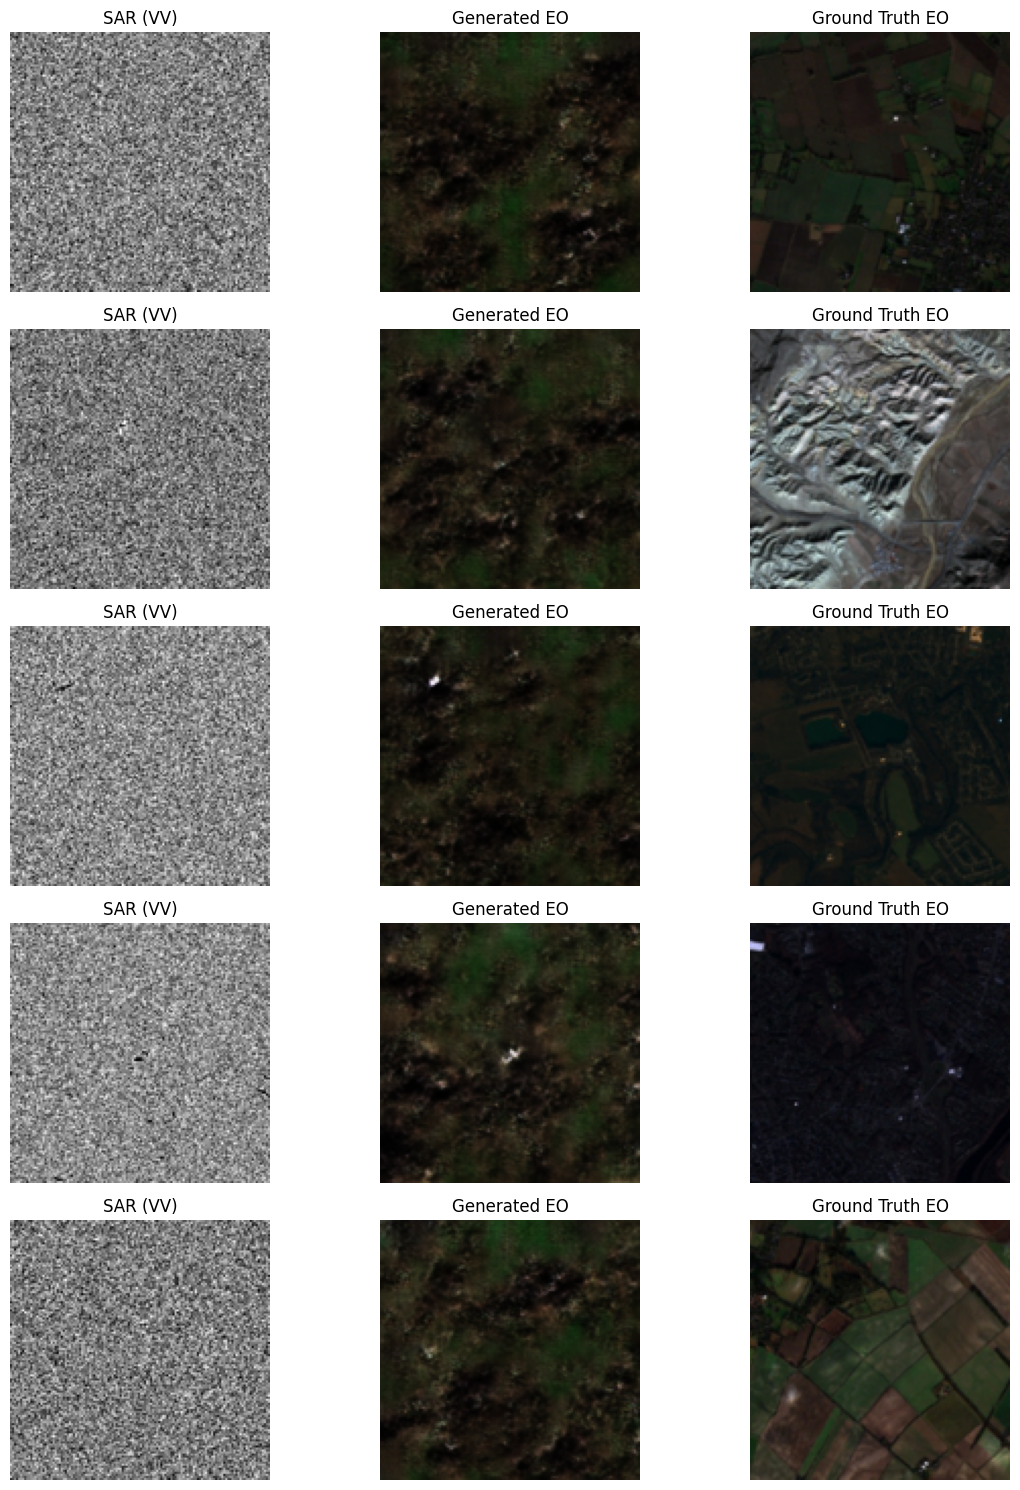

In [69]:
fig, axes = plt.subplots(5, 3, figsize=(12, 15))
for i in range(5):
    axes[i,0].imshow(sar_imgs[i][...,0], cmap='gray')
    axes[i,0].set_title('SAR (VV)')
    axes[i,0].axis('off')
    axes[i,1].imshow(gen_eo_imgs[i])
    axes[i,1].set_title('Generated EO')
    axes[i,1].axis('off')
    axes[i,2].imshow(eo_imgs[i])
    axes[i,2].set_title('Ground Truth EO')
    axes[i,2].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sar2eo_comparison.png'))
plt.show()

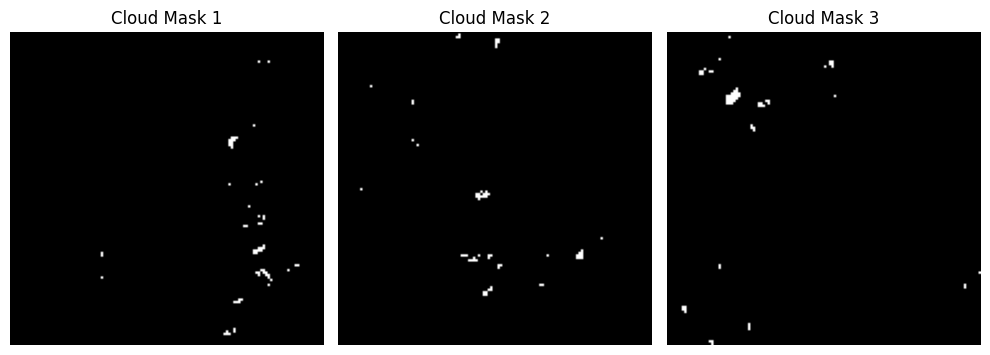

In [70]:
def compute_cloud_mask(eo_img, threshold=0.2):
    blue = eo_img[...,2] if eo_img.shape[-1] > 2 else eo_img[...,0]
    mask = (blue > (threshold*255)).astype(np.uint8)
    return mask

plt.figure(figsize=(10,6))
for i in range(3):
    mask = compute_cloud_mask(gen_eo_imgs[i])
    plt.subplot(1,3,i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Cloud Mask {i+1}')
    plt.axis('off')
    Image.fromarray((mask*255).astype(np.uint8)).save(os.path.join(output_dir, f'cloud_mask_{i}.png'))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cloud_masks.png'))
plt.show()

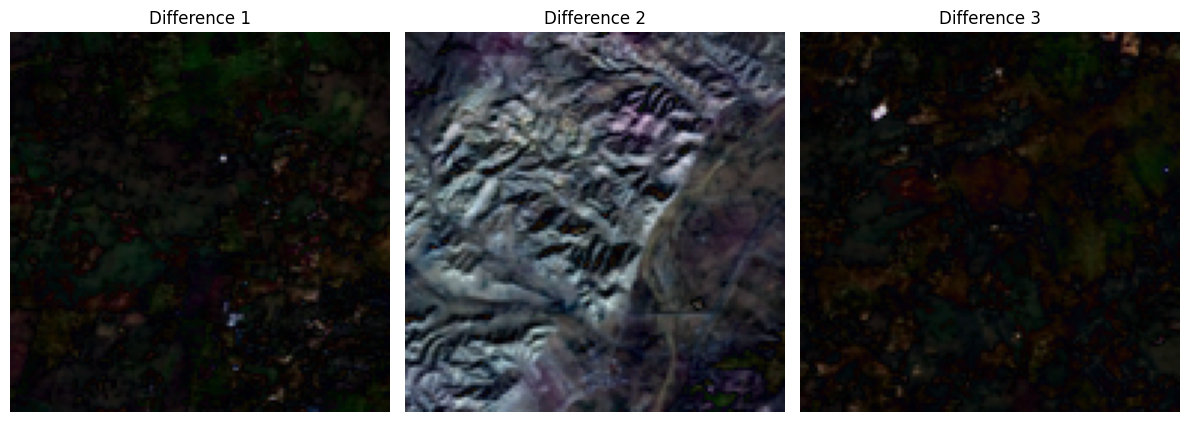

In [71]:
plt.figure(figsize=(12,8))
for i in range(3):
    diff = np.abs(gen_eo_imgs[i].astype(np.float32) - eo_imgs[i].astype(np.float32))
    plt.subplot(1,3,i+1)
    plt.imshow(diff.astype(np.uint8))
    plt.title(f'Difference {i+1}')
    plt.axis('off')
    Image.fromarray(diff.astype(np.uint8)).save(os.path.join(output_dir, f'diff_{i}.png'))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'eo_differences.png'))
plt.show()